# Neutrino direction reconstruction using events from a fixed source and Kotera Max flux


### Jan 14, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
my_path_plots = os.path.abspath("./plots/")

Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


In [3]:
def nuDirReco(polVec,propVec,viewAng):
    propVec = -propVec
    recoDir = np.sin(viewAng)*polVec-np.cos(viewAng)*propVec
    return recoDir

def SphericalToCartesian(phi, theta):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    
    return np.array([x,y,z])
chAngle = 55.8 #Cherenkov angle in ice

In [4]:
appended_data = []
import os
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/noiseOn/window_Sol0"):#Loop over desired directory
        if (filename.startswith("pol_quant")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/noiseOn/window_Sol0/", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data) 
# recoNu = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/debug/pol_quant_noiseless.pkl")
# recoNu = recoNu.loc[abs(recoNu.maxV)>1]
# recoNu = recoNu.loc[abs(recoNu.maxV)<1350]
# recoNu = recoNu.loc[abs(recoNu.maxH)>1]
# recoNu = recoNu.loc[abs(recoNu.maxH)<1350]
recoNu = recoNu.loc[recoNu.theta_reco>=np.pi/2]
# recoNu = recoNu.loc[recoNu.weight>1E-100]
# recoNu["SNR_V"] = abs(recoNu.maxV)/recoNu.rmsV
# recoNu["SNR_H"] = abs(recoNu.maxH)/recoNu.rmsH
# recoNu = recoNu.loc[abs(recoNu.SNR_H-5)<1]
# recoNu = recoNu.loc[recoNu.SNR_H>=5]
# recoNu = recoNu.loc[recoNu.SNR_V>=5]
print(len(recoNu))


array2 = []
R_True = []
R_Reco = []
propVec = []
dot = []
nnu_Reco = []
rec_angle = []
for i in recoNu.itertuples(): 
    thetaHat = np.array([np.cos(i.theta_reco)*np.cos(i.phi_reco), np.cos(i.theta_reco)*np.sin(i.phi_reco), -np.sin(i.theta_reco)])
    phiHat = np.array([-np.sin(i.phi_reco), np.cos(i.phi_reco),0])
    if(i.powerH==0 or i.powerV==0):
        R_Reco.append(np.nan)
        R_True.append(np.nan)
        array2.append(np.nan)
        dot.append(np.nan)
        nnu_Reco.append(np.nan)
        rec_angle.append(np.nan)
        continue
    R_Reco.append(np.sqrt(i.powerH/i.powerV))
#     R_Reco.append(abs(i.peak_H/i.peak_V))
    R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
    R_True.append(R)
    array2.append(util.PolVectorRecoPower_debug(i.powerV,i.powerH, i.theta_reco, i.phi_reco,np.sign(R)))
    phi_launch = np.arctan2(i.dirProp[1],i.dirProp[0])
    theta_launch = np.pi-i.launch_ang
    launchVec = SphericalToCartesian(phi_launch,theta_launch)
    nnu_Reco.append(nuDirReco(i.PolTrue,launchVec,i.view_ang))
    propVec = np.array([np.sin(i.theta_reco)*np.cos(i.phi_reco),np.sin(i.theta_reco)*np.sin(i.phi_reco),np.cos(i.theta_reco)])
    dot.append(np.dot(propVec,i.PolTrue))
    rec_angle.append(np.arccos(i.dirProp[2]))
recoNu["PolReco2"] = array2
recoNu["nnu_Reco"] = nnu_Reco
recoNu["rec_angle"] = rec_angle

recoNu["R_True"] = R_True
recoNu["R_Reco"] = R_Reco
recoNu["dotProd"] = dot
recoNu = recoNu.dropna()

Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

Px_reco = np.array([element[0] for element in recoNu.PolReco2])
Py_reco = np.array([element[1] for element in recoNu.PolReco2])
Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


nnuX_true = np.array([element[0] for element in recoNu.nnu])
nnuY_true = np.array([element[1] for element in recoNu.nnu])
nnuZ_true = np.array([element[2] for element in recoNu.nnu])

nnuX_reco = -1*np.array([element[0] for element in recoNu.nnu_Reco])
nnuY_reco = -1*np.array([element[1] for element in recoNu.nnu_Reco])
nnuZ_reco = -1*np.array([element[2] for element in recoNu.nnu_Reco])

thetaNnu_true = np.degrees(np.arccos((nnuZ_true)))
thetaNnu_reco = np.degrees(np.arccos((nnuZ_reco)))
phiNnu_true = np.degrees(np.arctan((nnuY_true)/(nnuX_true)))
phiNnu_reco = np.degrees(np.arctan((nnuY_reco)/(nnuX_reco)))

recoNu["thetaNnu_reco"] = thetaNnu_reco
recoNu["phiNnu_reco"] = phiNnu_reco
recoNu["thetaNnu_true"] = thetaNnu_true
recoNu["phiNnu_true"] = phiNnu_true
recoNu["delta"] = thetaNnu_reco-thetaNnu_true
recoNu["deltaPhi"] = phiNnu_reco-phiNnu_true

recoNu = recoNu.dropna()

158887


/usr/local/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/deDisperse_util.py:625: RuntimeWarning: invalid value encountered in sqrt
  R = np.sqrt(powerH/powerV)*signR
/usr/local/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in arccos


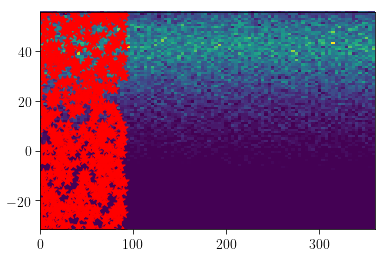

In [5]:
plt.hist2d(np.degrees(recoNu.phi_reco),90-np.degrees(recoNu.theta_reco)+chAngle, bins=100, weights=recoNu.weight);
plt.scatter(recoNu.phiNnu_true[0],90-recoNu.thetaNnu_true[0],s=100,c="red",marker="*",label ="True source")

# plt.ylim(50,125)

In [6]:
plt.hist2d(np.degrees(recoNu.phi_antenna),90-np.degrees(recoNu.theta_antenna)+chAngle, bins=100, weights=recoNu.weight);
plt.scatter(recoNu.phiNnu_true[0],recoNu.thetaNnu_true[0]-90,s=100,c="red",marker="*",label ="True source")

plt.ylim(40,70)

AttributeError: 'DataFrame' object has no attribute 'phi_antenna'

In [ ]:
plt.hist2d(recoNu.phiNnu_reco,recoNu.thetaNnu_reco, bins=200, weights=recoNu.weight);
plt.scatter(recoNu.phiNnu_true[0],recoNu.thetaNnu_true[0],s=100,c="red",marker="*",label ="True source")
plt.legend()
# plt.xlim(-20,20)
# plt.ylim(131,135)
plt.xlabel("$\phi$")
plt.ylabel("$\\theta$")

# Convert to Galactic coordinates with AstroPy

In [ ]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.coordinates as coord
from astropy.io import ascii

In [ ]:
galactic_longitudes = np.arange(start=0, stop=360, step=0.1)
galactic_latitudes = [0] * len(galactic_longitudes)
icrs = SkyCoord(galactic_longitudes, galactic_latitudes, unit="deg", frame="galactic").icrs
gal_ra = icrs.ra
gal_ra = gal_ra.wrap_at(180*u.degree)
gal_dec = icrs.dec

gal_center_long = 180.
gal_center_lat = 0.
cena_long = 309.51589568
cena_lat = 19.41727350
icrs2 = SkyCoord(gal_center_long, gal_center_lat, unit="deg", frame="galactic").icrs
gal_center_ra = icrs2.ra
gal_center_ra = gal_center_ra.wrap_at(180*u.degree)
gal_center_dec = icrs2.dec

icrs3 = SkyCoord(cena_long, cena_lat, unit="deg", frame="galactic").icrs
#cena_ra = icrs3.ra
#cena_ra = cena_ra.wrap_at(180*u.degree)
#cena_dec = icrs3.dec
ra_gc=np.degrees(recoNu.phi_antenna)*u.degree
dec_gc=(np.degrees(recoNu.theta_antenna)-chAngle)* u.degree
ra_cena = 201.3625*u.degree
dec_cena = -43.0192*u.degree

true_ra = (recoNu.phiNnu_true[9])*u.degree
true_dec = (recoNu.thetaNnu_true[9]-90)*u.degree
c2 = SkyCoord(ra=true_ra, dec=true_dec, frame='icrs')
true_ra = c2.ra.wrap_at(180 * u.deg).radian
true_dec = c2.dec.radian

reco_ra = (recoNu.phiNnu_reco)*u.degree
reco_dec = (recoNu.thetaNnu_reco-90)*u.degree
c3 = SkyCoord(ra=reco_ra, dec=reco_dec, frame='icrs')
reco_ra = c3.ra.wrap_at(180 * u.deg).radian
reco_dec = c3.dec.radian

In [ ]:
c = SkyCoord(ra=ra_gc, dec=dec_gc, frame='icrs')
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111, projection="hammer")
ra_rad = c.ra.wrap_at(180 * u.deg).radian
dec_rad = c.dec.radian
ax.grid(color='k', linestyle='solid', linewidth=0.5)
r = 90

plt.plot(true_ra, -true_dec, '*',color='firebrick',markersize=15,mec='green',label='True source')
plt.scatter(ra_rad, -dec_rad, alpha=0.6,label='Interferometric reco.')
plt.scatter(reco_ra, -reco_dec, alpha=0.6,label='Reco source (interf. + pol. info)')


# plt.scatter(recoNu.phiNnu_true[0]*u.degree,(recoNu.thetaNnu_true[0])*u.degree,c="red",marker="*",label ="True source")

# ax.plot(cena_ra, cena_dec,'^',markersize=9,color='m',label='Centaurus A')
# plt.plot(gal_ra.radian[0:2970], -gal_dec.radian[0:2970],color='firebrick',linewidth=2,label='Galactic Plane',zorder=1)
# plt.plot(gal_ra.radian[2980:], -gal_dec.radian[2980:],color='firebrick',linewidth=2,zorder=2)

 

# legend.get_frame().set_facecolor('#ffe4c4')
ax.legend(loc = 'upper left')
ax.set_ylabel('Dec (deg)') #give it a title
ax.set_xlabel('RA (deg)',labelpad=20) #give it a title
ax.axes.get_xaxis().set_ticks([-np.pi/3, -2*np.pi/3, -np.pi,0,np.pi/3, 2*np.pi/3, np.pi])
plt.title("Directional reconstruction using MC truth",y=1.08)

ax_new = fig.add_axes([0.6, 0.6, 0.25, 0.2]) # the position of zoom-out plot compare to the ratio of zoom-in plot 

plt.plot(np.degrees(true_ra), np.degrees(-true_dec), '*',color='firebrick',markersize=15,mec='green',label='True source')
plt.scatter(np.degrees(ra_rad), np.degrees(-dec_rad), alpha=0.6,label='Interferometric reco.')
plt.scatter(np.degrees(reco_ra), np.degrees(-reco_dec), alpha=0.6,label='Reco source (interf. + pol. info)')
ax_new.set_xticks(np.arange(-80,80,20))
ax_new.set_yticks(np.arange(-60,40,10))
ax_new.grid()

for tick in ax_new.xaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
for tick in ax_new.yaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
plt.tight_layout()
# ax.show()
plt.savefig(my_path_plots+'/NuDirReco/SkyMap_fixedSourceKotera.png', dpi=250)

In [ ]:
from scipy.stats import gaussian_kde
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm

x=reco_ra
y=-reco_dec
# y = theta
xy = np.vstack([x,y])
kernel = gaussian_kde(xy, bw_method='silverman')

xmin = min(x)-.1
xmax = max(x)+.1
ymin = min(y)-.1
ymax = max(y)+.1

In [ ]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

In [ ]:
fig = plt.figure(figsize=(8,6))

# ax = fig.add_subplot(111, projection="hammer")

levels = [1e-2]

contours = plt.contour(X, Y, Z,levels,locator=plt.LogLocator(),colors="black")
# cmap = plt.contourf(X, Y, Z,200)
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(contours, contours.levels,color="black", fmt=fmt, inline=True)
# cmap=plt.pcolormesh(X, Y, Z,shading='gouraud', norm=colors.LogNorm(vmax=10))
plt.scatter(reco_ra, -reco_dec, alpha=0.6,label='Reco source (interf. + pol. info)')

# cmap = plt.get_cmap('PiYG')
# plt.colorbar(cmap,label='Probability density',norm=LogNorm())
plt.title("Hpol", fontsize=14)
plt.xlabel("$\phi$", fontsize=14)
plt.ylabel("$\cos(\\theta)$", fontsize=14)
plt.grid(color='k', linestyle='solid', linewidth=0.5)
plt.tight_layout()
# plt.savefig("KDE_CenA_recoPeak_300m_hpol.pdf", dpi=300)

In [ ]:
np.degrees(np.arccos(-0.03892302)) #From AraOut

In [ ]:
87.8875 #From AraSim

In [ ]:
180-np.degrees(np.arccos(-0.03892302)) #180-AraOut = AraSim

### Scatter plot of receiving angle vs launch angle

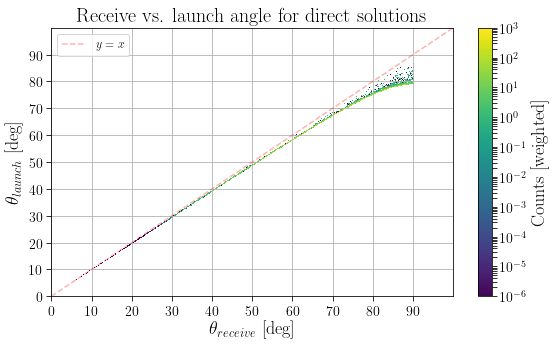

In [7]:
plt.figure(figsize=(8,5))
x = np.linspace(0,100,100)
y = x
plt.hist2d(np.degrees(np.pi-recoNu.rec_angle),np.degrees(recoNu.launch_ang),bins = 500, weights=recoNu.weight,norm=mpl.colors.LogNorm(vmin=1E-6,vmax=1E3));
plt.grid()
plt.colorbar(label="Counts [weighted]")
plt.xlabel("$\\theta_{receive}$ [deg]")
plt.ylabel("$\\theta_{launch}$ [deg]")
plt.title("Receive vs. launch angle for direct solutions")
plt.xlim(0,100)
plt.ylim(0,100)
plt.xticks(np.arange(0,100,10))
plt.yticks(np.arange(0,100,10))

plt.plot(x,y,"--", c = "red", alpha = 0.3, label = "$y=x$")
plt.legend()
plt.tight_layout()
plt.savefig(my_path_plots+'/NuDirReco/receive_vs_launch_direct.png', dpi=250)


In [10]:
newDF = recoNu[['rec_angle', 'launch_ang']].copy()
newDF

,rec_angle,launch_ang
0,2.084096,1.022523
2,1.737203,1.319686
0,2.194831,0.920198
0,2.181849,0.934720
0,2.338354,0.784954
...,...,...
142,1.985823,1.113160
143,1.966250,1.128449
145,1.826458,1.246338
150,2.057996,1.049154
